# Seasonality 
<img src=images/logo.png align='right' width=200>

## Goal

In this notebook we shall demonstrate how a contextual understanding (e.g. of seasons) can help our analysis.

## Program

- [Error-Trend-Seasonality Decomposition](#etsd)
- [Dealing with Seasonality](#dws)
- [Feature Engineering](#fe)
    - [Assignment](#as1)
- [Gradual Seasonal Filtering](#gsf)
- [Non-Constant Seasonality](#ncs)
    - [Assignment](#as2) 
- [Summary](#sum)


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import dates

from sklearn.linear_model import LinearRegression

%matplotlib inline 

## The data

For this notebook we will use a dataset containing total monthly passenger traffic at Schiphol airport between 1999 and 2019 from [Statistics Netherlands (CBS)](https://opendata.cbs.nl/statline/#/CBS/en/dataset/37478ENG/table?dl=6F18). Each datapoint indicates the total number of passengers traveled via Schiphol in millions in each particular month.

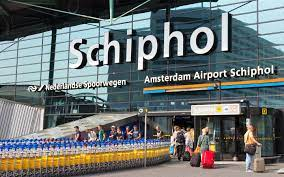

In [ ]:
schiphol = pd.read_csv('data/schiphol_passengers.csv', index_col='date', parse_dates=True)
# schiphol.index.freq='MS'
schiphol['total_passengers'] = schiphol['total_passengers'] / 1000000
schiphol.head()

In [ ]:
schiphol.info()

Let's verify that we have data for every month of the years in the dataset.

In [ ]:
(
    schiphol
    .resample('Y')
    .count()
    .head()
)

By plotting the data over time we can clearly see some patterns:

In [ ]:
schiphol.plot(figsize=(16,4));
schiphol['2004 Sep':'2006 Feb'].plot(figsize=(16,4));

These regularities can be described with some Time Series vocabulary:

- **Trends** (upward / horizontal / downward)
- **Seasonality** (predictably repeating cycles - weekly/monthly/yearly etc)
- **Non-cyclical components** (patterns with no set repetition - for example trend breaks or random shocks) 
- **Residuals** (the remaining part of the series that cannot be further explicitly modeled)

We will now investigate whether there is a way to separate the general trend from the other fluctuations?

<a id='etsd'></a>
## Error-Trend-Seasonality Decomposition

We may want to separate the time series into the trend, the seasonality and the error component. ETS decomposition can be achieved by creating a generalized model that fits our data.

`seasonal_decompose` from  `statsmodels` library can quickly provide a simple/naïve ETS decomposition:

Each datapoint is split into a trend $Y_t$, seasonal $S_t$ and residual $e_t$ components.

$$Y[t] = T[t] + S[t] + e[t]$$

The trend is achieved by applying a convolution filter (a form of smoothing) to the data. 

To get the seasonality, first the trend is subtracted from the time series data and then the average period is computed for this de-trended series.

The error is the maining residual separating the sum of the trend and seasonality from the original time series data.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Decomposition = seasonal_decompose(schiphol['total_passengers'], model = 'additive', period=12)  

with plt.rc_context():
    plt.rc("figure", figsize=(16,10))
    Decomposition.plot();

If the trend appears to be non-linear, `model='multiplicative'` option can be used, which implies the above decomposition with the terms multiplied rather than added up:

$$Y[t] = T[t] * S[t] * e[t]$$

In [ ]:
Decomposition = seasonal_decompose(schiphol['total_passengers'], model = 'multiplicative', period=12)  

with plt.rc_context():
    plt.rc("figure", figsize=(16,10))
    Decomposition.plot();

We can directly access the separated data points for trend `Decomposition.trend`, seasonality `.seasonal` and residuals `.resid`

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
schiphol.plot(ax = ax)
Decomposition.trend.plot(ax = ax);

Building such decompositions helps to inspect and analyze the general behavior of a time series. 

**Note**: We are not using these models for forecasting - our focus for now is understanding the current data!

Another quick way to detect any recurrent patterns in the data is by using the *autocorrelation plot*. **Autocorrelation**, defined as the correlation of a signal with a delayed copy of itself, illustrates to what extent the present of a series can be inferred from its past. Any cyclical patterns in the autocorrelation plot are likely signs of seasonal fluctuations:

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize = (16,4))
plot_acf(schiphol['total_passengers'], lags=12, ax = ax);

Intuitively, we notice there is more correlation with the data from 12 months ago than the data 6 months ago.

<a id='dws'></a>
## Dealing with Seasonality
Seasonality obscures the actual signal, which can complicate both understanding of the underlying processes and further forecasting. 

Understanding it gets us closer to what actually happens in the data ― which also means easier forecasting.

One of the simplest ways to identify the main pattern(s) taking place in the data is to fit a linear regression. 

We can use it to learn the general trend of the data.

In [ ]:
schiphol['period_num'] = np.arange(len(schiphol.index))
X = schiphol[['period_num']]
y = schiphol['total_passengers'].values

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X, y)

In [ ]:
schiphol['pass_lin_pred'] = lm.predict(X)

In [ ]:
schiphol[['total_passengers','pass_lin_pred']].plot(figsize=(16,4));

We can evaluate the fit using the $R^2$ score - the closer to 1, the better the model captures the patterns in the data. Note though that this does not yet necessarily mean better forecasting ― we will get to this in the next notebook.

In [ ]:
print(f"R^2 is {round(lm.score(X, y),3)}")

A simple linear regression illustrates the overall passenger traffic growth over time, but (expectably) fails to take the 2009 drop into account. One way to correct this would be to introduce a dummy term for the data points after 2009:

In [ ]:
schiphol['after2009'] = [1 if el>=pd.Timestamp('2009') else 0 for el in schiphol.index]

X_break = (
    schiphol[['period_num','after2009']]
    .assign(interaction = lambda df: df.period_num*df.after2009)
)
X_break.loc['2008-11':'2009-02']

<mark>**Question**: Why is it helpful to inclue an interaction term as well as the dummy variable?

In [ ]:
lm_break = LinearRegression().fit(X_break, y)

In [ ]:
print(f"Model coefficients {lm_break.coef_}")

In [ ]:
print(f"Model intercept {lm_break.intercept_}")

In [ ]:
schiphol['pass_lin_b_pred'] = lm_break.predict(X_break)

In [ ]:
schiphol[['total_passengers','pass_lin_b_pred']].plot(figsize=(16,4));

In [ ]:
print(f"R^2 is {round(lm_break.score(X_break, y),3)}")

This seems to be a much better fit. It also illustrates that even though passenger traffic dropped during the 2008-2009 Crisis, post-crisis growth appears to be more rapid than before.

<a id='fe'></a>
## Feature Engineering

We may want to do more than just identifying the trend though. 

Modeling the seasonality would allow us to understand and quantify the seasonal effects. And this means an ability to model not just the average behavior, but exact values during each season.

A simple way to achieve this would be to add seasonal dummy terms to the baseline linear regression. In fact, *feature engineering* can be a very powerful tool in Time Series Analysis, allowing us to capture rather complex patterns with a few simple engineered variables added.

In [ ]:
schiphol['quarter']=schiphol.index.quarter

X_quarter = schiphol[['period_num','quarter']]
X_quarter.head()

In the code below, we use `ColumnTransformer` - a handy tool from scikit-learn to apply some transformation to one column (*'quarter'*) and keep the rest unchanged. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
feature_transformer = ColumnTransformer(
     [('numeric', 'passthrough', ['period_num']),
      ('categorical', OneHotEncoder(drop='first'), ['quarter'])]
)

In [ ]:
pd.DataFrame(columns = feature_transformer.fit(X_quarter).get_feature_names_out(),
             data = feature_transformer.fit_transform(X_quarter)
            )

We further combine our preprocessing step with the model training using a Machine Learning pipeline from scikit-learn: a powerful way to keep both preprocessing and machine learning together in a single logical unit.

In [ ]:
from sklearn.pipeline import Pipeline

lm_quarter = Pipeline([
    ('preprocess', feature_transformer),
    ('model', LinearRegression())
])

In [ ]:
lm_quarter.fit(X_quarter, y)

In [ ]:
schiphol['pass_lin_q_pred'] = lm_quarter.predict(X_quarter)

In [ ]:
schiphol[['total_passengers','pass_lin_q_pred']].plot(figsize=(16,4));

In [ ]:
print(f"R^2 is {round(lm_quarter.score(X_quarter, y),3)}")

This simple model appears to reasonably capture the observed seasonality (even if it fails to acknowledge the drop after the 2008-2008 Financial Crisis). Actual seasonality seems more complex than just fixed quarterly jumps or drops, but this approach already illustrates the main patterns. 

Moreover, it already allows us to separate seasonality from the trend and the residuals. We can compute the average seasonal effeect by averaging out the seasonal coefficients.:

In [ ]:
print(f"Seasonal coefficients {lm_quarter['model'].coef_[1:]}")

In [ ]:
average_season_effect = (0.25 * lm_quarter['model'].coef_[1:]).sum()
average_season_effect

We can then use this average seasonal effect to compute an ETS decomposition.

In [ ]:
simple_ets = (
    schiphol
    .loc[:,['total_passengers','pass_lin_q_pred']]
    .rename(columns={"total_passengers": "y_real", "pass_lin_q_pred": "y_hat"})
    .assign(trend = lambda df: lm_quarter['model'].coef_[0]*np.arange(len(df))
                               + average_season_effect
                               + lm_quarter['model'].intercept_,
            seasonal = lambda df: df['y_hat'] - df['trend'],
            residuals = lambda df: df['y_real'] - df['y_hat'])
)
simple_ets.head()

In [ ]:
simple_ets[['y_real','y_hat','trend']].plot(figsize=(16,4))
simple_ets[['seasonal']].plot(figsize=(16,2), c='m')
simple_ets[['residuals']].plot(figsize=(16,2), c='r');

Having broken down a time series into its major components, we can now also *detrend* or *deseasonalize* it by subtracting the respective components. This can provide us with a clearer picture of what is going on over time aside from the trend and/or the seasonal fluctuations.

In [ ]:
simple_ets = (simple_ets
              .assign(deseasonalized = lambda df: df['y_real']-df['seasonal'],
                      detrended = lambda df: df['y_real']-df['trend']))

simple_ets[['deseasonalized']].plot(figsize=(16,3), c='g', label="deseasonalized time series")
simple_ets[['detrended']].plot(figsize=(16,3), c='m', label="detrended time series");

In case it is unclear from the residuals plot, we can also inspect the autocorrelation plot for the residuals to see if we have likely missed some important (seasonal) patterns with out model. In this case, based on the remaining autocorrelation in the residuals, our seasonality representation is clearly a bit too simplistic:

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
plot_acf(simple_ets['residuals'], lags=12, ax=ax);

<a id='as1'></a>
## Assignment: Monthly Dummies

- Instead of the quarterly dummies, add monthly dummies
- Add a post-2009 dummy
- **Optional**: add interaction and polynomial terms for all features

Fit the resulting model: is it a better fit?

*you can load an example answer below:*

In [ ]:
# %load answers/month_dummies.py

<a id='gsf'></a>
## Gradual Seasonal Filtering

Often seasonal effects do not come just as fixed spikes or drops. They may have gradually increasing and decreasing effects as their peak approaches and moves away in time. 

In such cases we may want to use a neat alternative to seasonal dummies: *gradual seasonal filters*.

There are a variety of such features that we could create. 

### Linear

A simple yet effective example are linear monthly spikes:

$$ \phi(x_i) = \max( 1 - \frac{| x - x^*|}{n} , 0)$$

where $x$ is a given data point, $x^*$ is the peak of the current filter, and $n$ is the interval of growth/decline of the spike around the peak (e.g. 30 days). 

In [ ]:
def gsf_feature_maker(day, center_day, year_days = 365, n=30):
    return np.max(
        [np.fmax(-np.abs(day - center_day)/n + 1, 0),
        np.fmax(-np.abs(day + year_days - center_day)/n + 1, 0),  #ensures continuity for December-January
        np.fmax(-np.abs(day - year_days - center_day)/n + 1, 0)]) #ensures continuity for December-January

In practice, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak.

In [ ]:
base = [gsf_feature_maker(el, 15) for el in np.arange(365)]
plt.figure(figsize = (17,3))
plt.plot(base);

A separate filter can be assigned to each potential seasonal peak — each month in the example below.

In [ ]:
months = pd.date_range('2008-01-01', periods = 12, freq = 'M')

fig, ax = plt.subplots(figsize=(17,3))
for month in months:
    ax.plot([gsf_feature_maker(el, month.dayofyear) for el in np.arange(365)])

This means an effect is not felt uniformly across a month, but increases/decreases depending on the distance from the desginated centre.

### Guassian

Another commonly used option are filters based on a *Gaussian distribution*:

$$ \phi(x_i) = \exp [ - \frac{1}{2\alpha} (x-m_i)^2]$$

where $x$ is a given data point, $m_i$ is the peak of the current filter, and $\alpha$ is a parameter responsible for the spread of the distribution. 

In [ ]:
def rbf_feature_values(day, center_day, year_days = 365, alpha = 0.005):
    return np.max(
        [np.exp(-((day - center_day)**2) / 2*alpha),
        np.exp(-((day + int(year_days) - center_day)**2) / 2*alpha)]) #ensures continuity for December-January

Again, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak. However, the effect is much smoother.

Depending on $\alpha$, very steep or very gradual filters can be created.  Such gradual filters could be especially handy when dealing with daily (or even hourly) data that typically exhibits more gradual seasonal effects. 

In [ ]:
base = [rbf_feature_values(el, 350, alpha = 0.001) for el in np.arange(365)]
plt.figure(figsize = (17,3))
plt.plot(base);

Again, a separate filter can be assigned to each potential seasonal peak — each month in the example below.

In [ ]:
months = pd.date_range('2008-01-01', periods = 12, freq = 'M')

fig, ax = plt.subplots(figsize=(17,3))
for month in months:
    ax.plot([rbf_feature_values(el, month.dayofyear) for el in np.arange(365)])

### Modelling with a seasonal filter

We will use the Gaussian filter to add seasonal features to our data

In [ ]:
schiphol_rbf = (
    schiphol
    [['total_passengers', 'after2009']]
    .assign(month = lambda df: df.index.month)
)
schiphol_rbf.head()

In [ ]:
#Adding 12 RBF features to the dataset
from calendar import month_name
month_in_days = [date.dayofyear for date in schiphol_rbf.index[:12]]

for i in range(12):
    feature_name = month_name[i+1]
    peak = month_in_days[i]
    schiphol_rbf[feature_name] = [rbf_feature_values(date.dayofyear, peak).round(2) for date in schiphol_rbf.index]

We now have 12 extra features corresponding to the effects of Gaussians filters for each month.

In [ ]:
schiphol_rbf.head()

Now we can illustrate how such RBF features look like for our dataset, where we only have monthly (not-daily) values:

In [ ]:
schiphol_rbf[['April', 'October']].loc['2014':].plot(figsize=(17,3));

we can train a model using these RBF features:

In [ ]:
time_var = np.arange(len(schiphol_rbf.index)).reshape(-1, 1)
X_rbf = np.c_[time_var, schiphol_rbf.iloc[:,3:]]
y = schiphol_rbf['total_passengers']

In [ ]:
lm_rbf = LinearRegression().fit(X_rbf, y)

In [ ]:
schiphol_rbf['pass_rbf_pred'] = lm_rbf.predict(X_rbf)

In [ ]:
schiphol_rbf[['total_passengers','pass_rbf_pred']].plot(figsize=(16,4));

In [ ]:
print(f"R^2 is {round(lm_rbf.score(X_rbf, y),3)}")

### RBF with Scikit-Lego

In case you do not want to create such RBF features manually, this preprocessing method is already implemented in a library called [Scikit-Lego](https://scikit-lego.netlify.app/index.html):

In [ ]:
from sklego.preprocessing import RepeatingBasisFunction

rbf = RepeatingBasisFunction(n_periods=12,
                             remainder='passthrough',
                             column='month',
                             input_range=(1,13))

In [ ]:
Xt = rbf.fit_transform(schiphol_rbf[['month']])
sklego_rbf = pd.DataFrame(columns=month_name[1:], data=Xt).round(2)
sklego_rbf.head(12)

In [ ]:
# February
sklego_rbf.iloc[:12,1].plot();

### Gradual Seasonal Filtering Summary

**Pros** 

- Simple feature engineering trick
- All variables are interpretable
- Seasonal effects can be quantified
- Can filter out the long term seasonality, other fluctuations can be modeled separately

**Cons** 

- The model can get a bit biased to beliefs about seasonality
- The model may have issues if the seasonality changes over time

<a id='ncs'></a>
## Non-Constant Seasonality

One drawback of simple RBF features that we have used above is that they model constant seasonality, while this may often be an incorrect assumption. We have seen above that the fitted cycles are perhaps too large for the first few years and too small for the last few years.

A simple solution to this problem is to create a new set of similar rbf features but then multiplied by the time period. This will allow fitted seasonal cycles to scale with time

<a id='as2'></a>
## Assignment: Non-Constant Seasonality 

- Add 12 new rbf and time interaction features (rbf x time) to our previous model. 
- Also add the after2009 dummy. 
- Fit the model and plot the results.

What changed about seasonality?

*you can load the answer below:*

In [ ]:
# %load answers/nc_seasonality.py

<a id='sum'></a>
## Summary

We have covered: 

- How time series data can be broken down into components:
    - Trends 
    - Seasonality 
    - Non-cyclical components 
    - Residuals 
- How to model the trend using linear regression.
- How to model seasonality using dummy variables and gradual seaonal filters.